##  Ingest

This notebook demonstrates how to classify chest X-ray images using a vision transformer (ViT) model. 

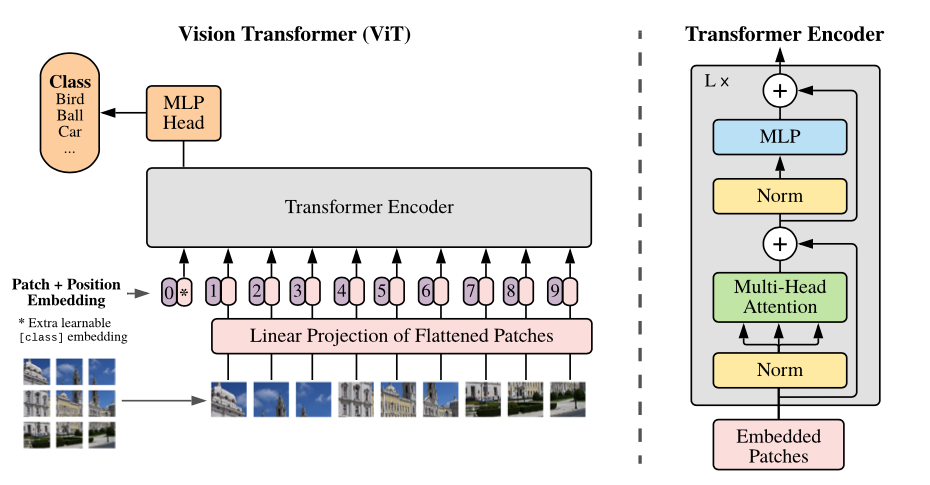

**Import requirments**

In [ ]:
import torch
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import transforms

In [7]:
from pathlib import Path

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---

**Dataset Overview**

For this project, we will be utilizing a chest X-ray dataset available on Kaggle. You can access and download the dataset via the following link:

**[Chest X-Ray Images Dataset](https://www.kaggle.com/datasets/jaberjaber/updatedxray/data)**

This dataset contains chest X-ray images categorized into four distinct classes:
1. **COVID-19**: X-ray images from patients diagnosed with COVID-19.
2. **Normal**: X-ray images from healthy individuals without any respiratory disease.
3. **Pneumonia-Bacterial**: X-ray images from patients diagnosed with bacterial pneumonia.
4. **Pneumonia-Viral**: X-ray images from patients diagnosed with viral pneumonia.

Make sure to download and upload the dataset files to your Colab environment to proceed with the analysis.

---

**Dataset Summary**

- **Train Set**: 6,902 images belonging to 4 classes.
- **Validation Set**: 923 images belonging to 4 classes.
- **Test Set**: 1,384 images belonging to 4 classes.

---

In [5]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive (15).zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [8]:
data_paths = Path('/content/tmp')
train_dir= data_paths / '/content/tmp/data_split/train'
test_dir = data_paths / '/content/tmp/data_split/train'
valid_dir = data_paths / '/content/tmp/data_split/validation'
#valid_dir = data_paths / 'validation'
#test_dir = data_paths / 'test'
BATCH_SIZE = 32

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

## Preprocessing

In [ ]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
train_dataloader, _, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_train)
_, test_dataloader, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_test)
_, valid_dataloader, classnames = create_dataloaders(train_dir=train_dir, test_dir= valid_dir, batch_size=BATCH_SIZE,transform = transforms_test)

In [ ]:
img, label = next(iter(train_dataloader))
img, label = img[0], label[0]

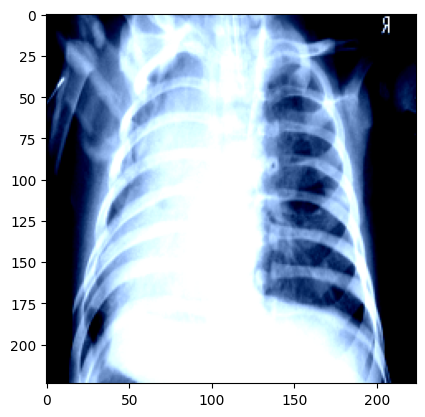

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

In [ ]:
EPOCHS = 10

## Helper Functions

In [ ]:
# this code is from github repe that I take from

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import seaborn as sns
def train_step(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Dict[str, float]:

    model.train()
    train_loss, train_acc = 0, 0
    all_labels, all_preds = [], []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        all_labels.extend(y.cpu().numpy())
        all_preds.extend(y_pred_class.cpu().numpy())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    train_precision = precision_score(all_labels, all_preds, average='weighted')
    train_recall = recall_score(all_labels, all_preds, average='weighted')
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        "loss": train_loss,
        "accuracy": train_acc,
        "precision": train_precision,
        "recall": train_recall,
        "f1": train_f1
    }

def test_step(model: torch.nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[Dict[str, float], List[int], List[int]]:

    model.eval()
    test_loss, test_acc = 0, 0
    all_labels, all_preds = [], []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(test_pred_labels.cpu().numpy())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        "loss": test_loss,
        "accuracy": test_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }, all_labels, all_preds

def train(model: torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_precision": [],
        "test_recall": [],
        "test_f1": []
    }

    model.to(device)

    final_all_labels = []
    final_all_preds = []

    for epoch in tqdm(range(epochs)):
        train_metrics = train_step(model=model,
                                   dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   device=device)
        test_metrics, all_labels, all_preds = test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

        if epoch == epochs - 1:
            final_all_labels = all_labels
            final_all_preds = all_preds

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_metrics['loss']:.4f} | "
          f"train_acc: {train_metrics['accuracy']:.4f} | "
          f"train_precision: {train_metrics['precision']:.4f} | "
          f"train_recall: {train_metrics['recall']:.4f} | "
          f"train_f1: {train_metrics['f1']:.4f} | "
          f"test_loss: {test_metrics['loss']:.4f} | "
          f"test_acc: {test_metrics['accuracy']:.4f} | "
          f"test_precision: {test_metrics['precision']:.4f} | "
          f"test_recall: {test_metrics['recall']:.4f} | "
          f"test_f1: {test_metrics['f1']:.4f}"
        )

        results["train_loss"].append(train_metrics['loss'])
        results["train_acc"].append(train_metrics['accuracy'])
        results["train_precision"].append(train_metrics['precision'])
        results["train_recall"].append(train_metrics['recall'])
        results["train_f1"].append(train_metrics['f1'])

        results["test_loss"].append(test_metrics['loss'])
        results["test_acc"].append(test_metrics['accuracy'])
        results["test_precision"].append(test_metrics['precision'])
        results["test_recall"].append(test_metrics['recall'])
        results["test_f1"].append(test_metrics['f1'])

    # Plot confusion matrix
    conf_matrix = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return results

from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## ViT model Training

ViT_B_16: This is a Vision Transformer model variant with a base configuration. The B indicates the base size, which refers to the model’s complexity and capacity (compared to small, large, or other configurations). The 16 represents the patch size, meaning the input image is divided into 16x16 pixel patches before being processed by the transformer.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install torchinfo
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights).to(device)

# Use torchinfo's summary instead
summary(model, input_size=(1, 3, 224, 224))

# Placeholder for training code
# results = train(model, train_dataloader, test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
#we can also freeze the parameters of the pre-trained model for better model (i try it below)
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights).to(device)

# Modify the classifier head
num_classes = 4
num_features = model.heads.in_features
model.heads = nn.Linear(num_features, num_classes).to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head to train it
for param in model.heads.parameters():
    param.requires_grad = True

summary(model, input_size=(1, 3, 224, 224))
'''

In [ ]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 | train_loss: 1.4380 | train_acc: 0.4114 | train_precision: 0.3738 | train_recall: 0.4110 | train_f1: 0.3582 | test_loss: 1.1293 | test_acc: 0.4967 | test_precision: 0.5208 | test_recall: 0.4974 | test_f1: 0.4051
Epoch: 2 | train_loss: 1.1799 | train_acc: 0.4975 | train_precision: 0.4460 | train_recall: 0.4975 | train_f1: 0.4421 | test_loss: 1.0966 | test_acc: 0.5870 | test_precision: 0.5813 | test_recall: 0.5878 | test_f1: 0.5730
Epoch: 3 | train_loss: 1.1446 | train_acc: 0.5289 | train_precision: 0.4800 | train_recall: 0.5288 | train_f1: 0.4725 | test_loss: 1.2427 | test_acc: 0.5009 | test_precision: 0.5768 | test_recall: 0.5016 | test_f1: 0.4126
Epoch: 4 | train_loss: 1.0621 | train_acc: 0.5580 | train_precision: 0.5235 | train_recall: 0.5578 | train_f1: 0.5102 | test_loss: 0.9722 | test_acc: 0.5835 | test_precision: 0.6519 | test_recall: 0.5843 | test_f1: 0.5030
Epoch: 5 | train_loss: 1.0153 | train_acc: 0.5871 | train_precision: 0.5598 | train_recall: 0.5869 | train_f1: 0

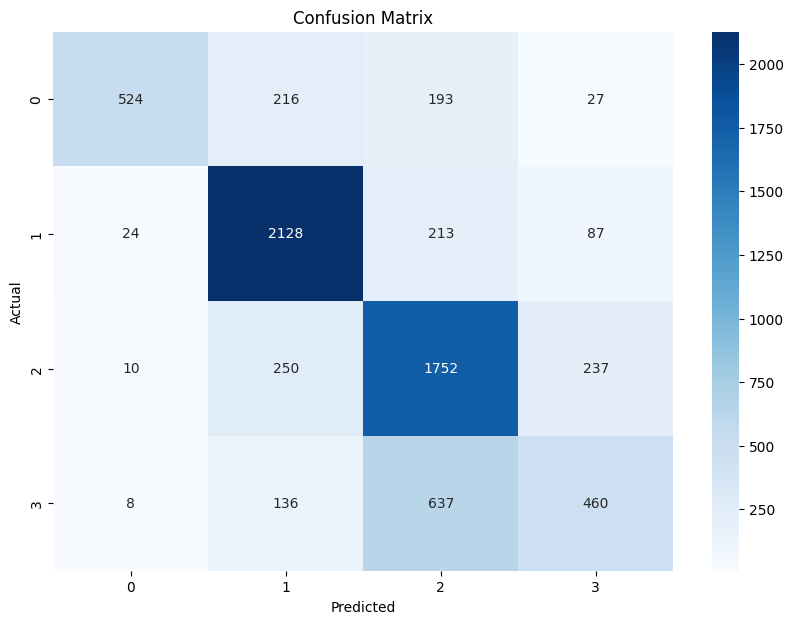

In [ ]:
results = train(model, train_dataloader, test_dataloader, optimizer = optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

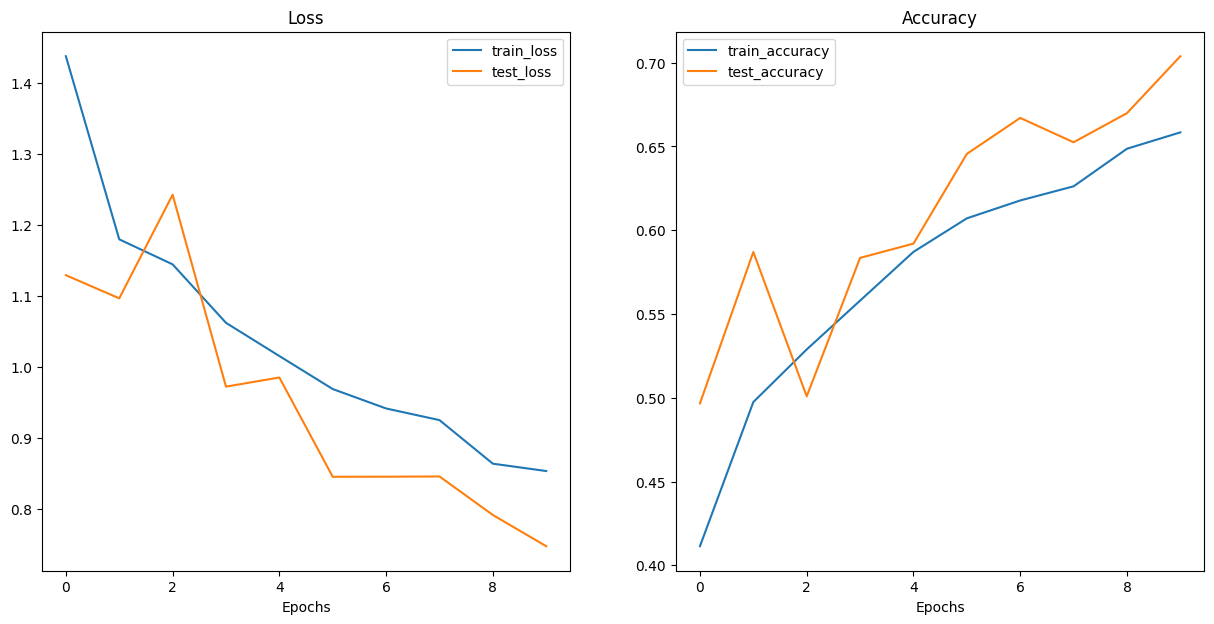

In [ ]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
save_model(model=model,
                 target_dir="models",
                 model_name="vitdlmodel.pth")

[INFO] Saving model to: models/vitdlmodel.pth


--------------------------------

The model with freezing the parameters

In [ ]:
import torch
import torch.nn as nn
import torchvision

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model with default weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model2 = torchvision.models.vit_b_16(weights=weights).to(device)

# Modify the classifier head
num_classes = 4
num_features = model.heads[0].in_features  # Accessing the Linear layer's in_features
model.heads = nn.Linear(num_features, num_classes).to(device)

# Freeze all layers
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the classifier head to train it
for param in model2.heads.parameters():
    param.requires_grad = True

# Print the model architecture
summary(model2, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6964 | train_acc: 0.7237 | train_precision: 0.7040 | train_recall: 0.7234 | train_f1: 0.7051 | test_loss: 0.5248 | test_acc: 0.7923 | test_precision: 0.7819 | test_recall: 0.7934 | test_f1: 0.7813
Epoch: 2 | train_loss: 0.5641 | train_acc: 0.7744 | train_precision: 0.7628 | train_recall: 0.7746 | train_f1: 0.7635 | test_loss: 0.4856 | test_acc: 0.8060 | test_precision: 0.7991 | test_recall: 0.8072 | test_f1: 0.7883
Epoch: 3 | train_loss: 0.5343 | train_acc: 0.7895 | train_precision: 0.7795 | train_recall: 0.7896 | train_f1: 0.7804 | test_loss: 0.4517 | test_acc: 0.8173 | test_precision: 0.8086 | test_recall: 0.8183 | test_f1: 0.8076
Epoch: 4 | train_loss: 0.5168 | train_acc: 0.7930 | train_precision: 0.7833 | train_recall: 0.7932 | train_f1: 0.7845 | test_loss: 0.4450 | test_acc: 0.8195 | test_precision: 0.8114 | test_recall: 0.8205 | test_f1: 0.8135
Epoch: 5 | train_loss: 0.5070 | train_acc: 0.7977 | train_precision: 0.7873 | train_recall: 0.7977 | train_f1: 0

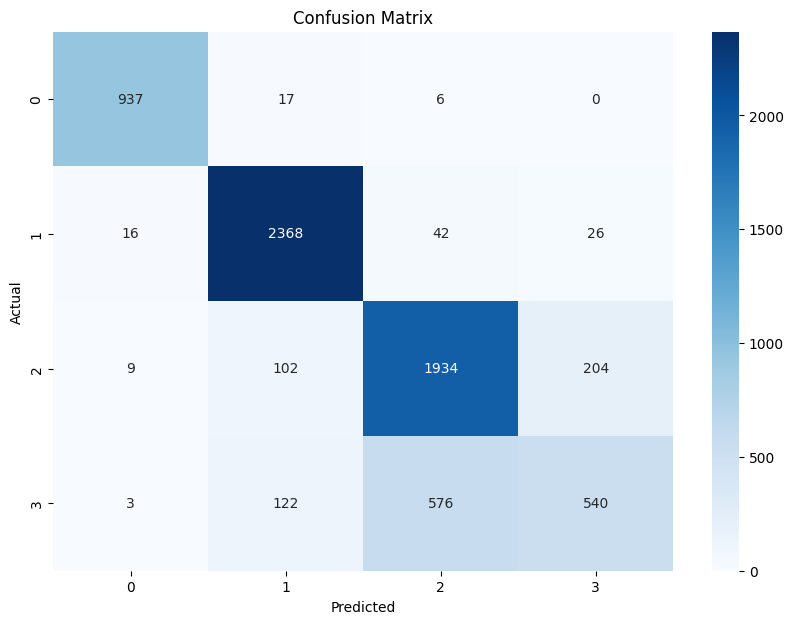

In [ ]:
results = train(model, train_dataloader, test_dataloader, optimizer = optimizer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

-----------------------------------------------------------

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp312-cp312-linux_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp312-cp312-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp312-cp312-linux_x86_64.whl.metadata (6.6 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (24.6 MB)
  Using cached https://download.pytorch.org/whl/

In [5]:
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
import torch
from torchvision import transforms, models
import io
from PIL import Image
import uvicorn
import numpy as np

# Initialize FastAPI app
app = FastAPI(title="Chest X-Ray Classification API",
              description="API for classifying chest X-ray images using Vision Transformer")

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)


# Define class names
class_names = ["COVID-19", "Normal", "Pneumonia-Bacterial", "Pneumonia-Viral"]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define image preprocessing
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# Load model
def load_model():
    try:
        # Load the model architecture
        model = models.vit_b_16()
        
        # Modify the classifier head for 4 classes
        num_features = model.heads.in_features
        model.heads = torch.nn.Linear(num_features, len(class_names))
        
        # Load the saved weights
        model.load_state_dict(torch.load("models/VitFinal30_model.pth", map_location=device))
        model.to(device)
        model.eval()
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

model = load_model()

@app.get("/")
def home():
    return {"message": "Chest X-Ray Classification API is running. Use /predict endpoint to classify images."}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    if not file:
        raise HTTPException(status_code=400, content="No file provided")
    
    if model is None:
        raise HTTPException(status_code=500, content="Model could not be loaded")
    
    try:
        # Read image
        content = await file.read()
        image = Image.open(io.BytesIO(content)).convert("RGB")
        
        # Preprocess image
        transform = get_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class_idx = torch.argmax(probabilities, dim=1).item()
            
            # Get all probabilities as a list
            probs = probabilities[0].cpu().numpy().tolist()
            
            result = {
                "prediction": class_names[predicted_class_idx],
                "confidence": float(probs[predicted_class_idx]),
                "probabilities": {class_names[i]: float(probs[i]) for i in range(len(class_names))}
            }
            
            return JSONResponse(content=result)
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error processing image: {str(e)}")

if __name__ == "__main__":
    uvicorn.run("app:app", host="0.0.0.0", port=8000, reload=True)

Error loading model: 'Sequential' object has no attribute 'in_features'


INFO:     Will watch for changes in these directories: ['/mnt/c/Users/mzlwm/OneDrive/Documents/GitHub/chest-xray-detection/notebooks']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [1552330] using StatReload
ERROR:    Error loading ASGI app. Could not import module "app".
INFO:     Stopping reloader process [1552330]
